In [1]:
# Importing useful libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier


In [2]:
default = pd.read_excel('./corona_tested_individuals_ver_006.english.xlsx')
default.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2020-04-30,0,0,0,0,0,negative,None,female,Other
1,2020-04-30,1,0,0,0,0,negative,None,female,Other
2,2020-04-30,0,1,0,0,0,negative,None,male,Other
3,2020-04-30,1,0,0,0,0,negative,None,female,Other
4,2020-04-30,1,0,0,0,0,negative,None,male,Other


### Data Preparation

In [93]:
# Dummy variables. Base values: female, other_education, not_married
default['contact_with_cofirmed'] = (default['test_indication'] == 'Contact with confirmed').astype('int')
default['abroad'] = (default['test_indication'] =='Abroad').astype('int')
default['other'] = (default['test_indication'] == 'Other').astype('int')
default['male'] = (default['gender']== 'male').astype('int')
default['result'] = (default['corona_result']== 'positive').astype('int')
default['has_cough'] = (default['cough']== '1').astype('int')
default['has_fever'] = (default['fever']== '1').astype('int')
default.drop(['gender','test_indication', 'corona_result', 'cough', 'fever'], axis=1, inplace=True)

In [94]:
default.head()

,test_date,sore_throat,shortness_of_breath,head_ache,age_60_and_above,contact_with_cofirmed,abroad,other,male,result,has_cough,has_fever
0,2020-04-30,0,0,0,None,0,0,1,0,0,0,0
1,2020-04-30,0,0,0,None,0,0,1,0,0,0,0
2,2020-04-30,0,0,0,None,0,0,1,1,0,0,0
3,2020-04-30,0,0,0,None,0,0,1,0,0,0,0
4,2020-04-30,0,0,0,None,0,0,1,1,0,0,0


In [95]:
default.columns

Index(['test_date', 'sore_throat', 'shortness_of_breath', 'head_ache',
       'age_60_and_above', 'contact_with_cofirmed', 'abroad', 'other', 'male',
       'result', 'has_cough', 'has_fever'],
      dtype='object')

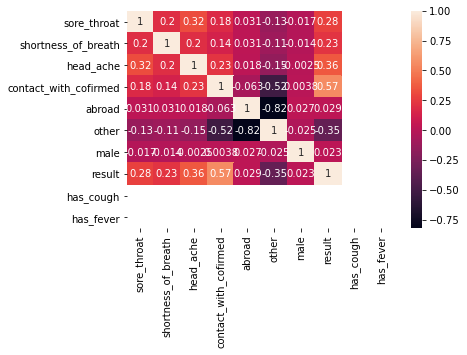

In [96]:
df_small = default.iloc[:,:13]
corr_mat = df_small.corr()

sns.heatmap(corr_mat, annot = True)
plt.show()

In [97]:
# Prepare Data
target_name = 'result'
topp_features = ['has_cough','has_fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'contact_with_cofirmed', 'abroad']
X = default[topp_features]
y = default[target_name]

In [98]:
X.columns

Index(['has_cough', 'has_fever', 'sore_throat', 'shortness_of_breath',
       'head_ache', 'contact_with_cofirmed', 'abroad'],
      dtype='object')

In [99]:
print(X)

        has_cough  has_fever  sore_throat  shortness_of_breath  head_ache  \
0               0          0            0                    0          0   
1               0          0            0                    0          0   
2               0          0            0                    0          0   
3               0          0            0                    0          0   
4               0          0            0                    0          0   
...           ...        ...          ...                  ...        ...   
278784          0          0            0                    0          0   
278785          0          0            0                    0          0   
278786          0          0            0                    0          0   
278787          0          0            0                    0          0   
278788          0          0            0                    0          0   

        contact_with_cofirmed  abroad  
0                           0      

In [24]:
print(y)

0         0
1         0
2         0
3         0
4         0
         ..
278784    0
278785    0
278786    1
278787    0
278788    0
Name: result, Length: 278789, dtype: int64


In [100]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=55, stratify=y)

In [101]:
#Building  Modell
def CMatrix(CM, result=['negative','positive']):
    df = pd.DataFrame(data=CM, index=result, columns=result)
    df.index.name='TRUE'
    df.columns.name='PREDICTION'
    df.loc['Total'] = df.sum()
    df['Total'] = df.sum(axis=1)
    return df

### Preparing a DataFrame for model analysis

In [102]:
# Data frame for evaluation metrics
metrics = pd.DataFrame(index=['accuracy', 'precision' ,'recall'], 
                      columns=['LogisticReg', 'Bagging', 'RandomForest', 'Boosting'])

**In this application:**
- **Accuracy**: Overall how often the model predicts correctly negatives(0's) and positives (1's)
- **Precision**: When the model predicts **positives**: how often is correct?
- **Recall**: The proportion of **actual positives** that the model will correctly predict as such

#### False negatives are worse. It is when the model predicts a person has no cofid 19 but he/she is realy infected => look for a better recall

## A. Logistic Regression

In [103]:
# 2. Create an instance of the estimator
logistic_regression = LogisticRegression(random_state=55)

# 3. Use the trainning data to train the estimator
logistic_regression.fit(X_train, y_train)
# 4. Evaluate the model
y_pred_test = logistic_regression.predict(X_test)
metrics.loc['accuracy','LogisticReg'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','LogisticReg'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','LogisticReg'] = recall_score(y_pred=y_pred_test, y_true=y_test)
#Confusion matrix
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)

PREDICTION,negative,positive,Total
TRUE,,,
negative,39052,559,39611
positive,919,1289,2208
Total,39971,1848,41819


## B. Bagging

In [104]:
# 2. Create an instance of the estimator
log_reg_for_bagging = LogisticRegression()
bagging = BaggingClassifier(base_estimator=log_reg_for_bagging, n_estimators=10,
                            random_state=55, n_jobs=-1)

# 3. Use the trainning data to train the estimator
bagging.fit(X_train, y_train)

# 4. Evaluate the model
y_pred_test = bagging.predict(X_test)
metrics.loc['accuracy','Bagging'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','Bagging'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','Bagging'] = recall_score(y_pred=y_pred_test, y_true=y_test)
#Confusion matrix
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)

PREDICTION,negative,positive,Total
TRUE,,,
negative,39052,559,39611
positive,919,1289,2208
Total,39971,1848,41819


## C. Random Forests

In [105]:
# 2. Create an instance of the estimator
RF = RandomForestClassifier(n_estimators=35, max_depth=20, random_state=55, max_features='sqrt',n_jobs=-1)

# 3. Use the trainning data to train the estimator
RF.fit(X_train, y_train)

# 4. Evaluate the model
y_pred_test = RF.predict(X_test)
metrics.loc['accuracy','RandomForest'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','RandomForest'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','RandomForest'] = recall_score(y_pred=y_pred_test, y_true=y_test)
#Confusion matrix
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)

PREDICTION,negative,positive,Total
TRUE,,,
negative,39026,585,39611
positive,844,1364,2208
Total,39870,1949,41819


## D. Boosting

In [106]:
# 2. Create an instance of the estimator
boosting = AdaBoostClassifier(n_estimators=50, learning_rate=0.1, random_state=55)    

# 3. Use the trainning data to train the estimator
boosting.fit(X_train, y_train)

# 4. Evaluate the model
y_pred_test = boosting.predict(X_test)
metrics.loc['accuracy','Boosting'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','Boosting'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','Boosting'] = recall_score(y_pred=y_pred_test, y_true=y_test)
#Confusion matrix
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)

PREDICTION,negative,positive,Total
TRUE,,,
negative,39078,533,39611
positive,1059,1149,2208
Total,40137,1682,41819


In [108]:
100*metrics

,LogisticReg,Bagging,RandomForest,Boosting
accuracy,96.4657,96.4657,96.5829,96.1931
precision,69.7511,69.7511,69.9846,68.3115
recall,58.3786,58.3786,61.7754,52.038


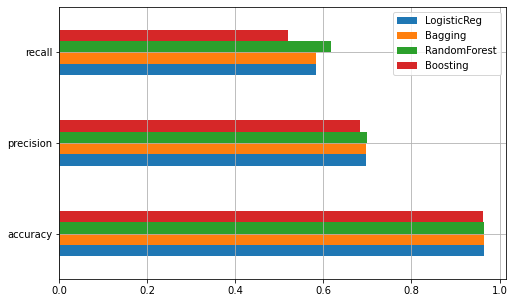

In [109]:
fig, ax = plt.subplots(figsize=(8,5))
metrics.plot(kind='barh', ax=ax)
ax.grid();

### Random Forest classifier with threshold of 0.01

In [111]:
y_pred_proba = RF.predict_proba(X_test)[:,1]
y_pred_test = (y_pred_proba >= 0.01).astype('int')
#Confusion matrix
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
print("Recall: ", 100*round(recall_score(y_pred=y_pred_test, y_true=y_test),2))
print("Precision: ", 100*round(precision_score(y_pred=y_pred_test, y_true=y_test),2))
CMatrix(CM)

Recall:  100.0
Precision:  5.0


PREDICTION,negative,positive,Total
TRUE,,,
negative,0,39611,39611
positive,0,2208,2208
Total,0,41819,41819


# Making predictions

In [112]:
# Retraining with all the observations
RF_final = RandomForestClassifier(n_estimators=35, max_depth=20, random_state=55, max_features='sqrt',n_jobs=-1)
# 3. Use the trainning data to train the estimator
RF_final.fit(X,y)


RandomForestClassifier(max_depth=20, max_features='sqrt', n_estimators=35,
                       n_jobs=-1, random_state=55)

In [116]:
# Making predictions
from collections import OrderedDict
symptoms = OrderedDict([('has_cough',  0), ('has_fever', 0), ('sore_throat', 1), ('shortness_of_breath', 1), ('head_ache', 1), ('contact_with_cofirmed', 1), ('abroad', 1)])

symtoms = pd.Series(symptoms).values.reshape(1,-1)

In [118]:
RF_final.predict(symptoms)

TypeError: float() argument must be a string or a number, not 'collections.OrderedDict'